In [50]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import plots
import random
import set_dataset as ds
import verificacion as ver
from sklearn.model_selection import train_test_split


In [51]:
def define_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

define_seed(seed=1029)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 

In [52]:
#Funcion para abrir los datos .npz y extraer las variables que elegimos, y lo guardamos en un diccionario
def get_data(path, var_input, var_target, train_ratio, val_ratio, test_ratio,get_name=None):
    

    #Cargamos el archivo npz
    data_from_file  = np.load(path) 

    #Generamos un diccionario vacio para almacenar variables
    Data=dict()

    #Cargamos todos los datos de precipitacion de nuestro modelo
    Input = data_from_file[var_input]

    #Cargamos todos los datos de precipitacion observado
    Target = data_from_file[var_target]
  
    #En este caso tanto el input como el target tiene las mismas dimensiones, por eso podemos usarlas para ambos
    Data["len_total"], Data["nx"], Data["ny"]  = Input.shape
    
    indices = range(Data["len_total"]) #Con el largo del dataset cuento cuantos hay y genero un vector de indices

    #Separo en los conjuntos de Entrenamiento y un conjunto que será Validacion/Testing
    train_ids, rest_ids = train_test_split(indices, test_size=1 - train_ratio , shuffle=False )
    #Ahora a ese conjunto restante lo divido en Validacion y testing propiamente.
    val_ids, test_ids   = train_test_split(rest_ids, test_size=test_ratio/(test_ratio + val_ratio) , shuffle=False ) 


    #Guardo e imprimo por pantalla la cantidad de datos en cada conjunto
    Data["len_train"], Data["len_val"], Data["len_test"] = len(train_ids), len(val_ids), len(test_ids)

    print('--------------Indices------------------------')

    #-------------------------------------------------------
    print('Training set starts at :', str( np.min( train_ids) ) , ' and ends at: ', str( np.max( train_ids ) ) )
    print('Validation set starts at :', str( np.min( val_ids ) ) , ' and ends at: ', str( np.max( val_ids ) ) )
    print('Testing set starts at: ', str( np.min( test_ids ) ) , ' and ends at: ', str( np.max( test_ids ) ) )
    
    #Seleccionamos datos para nuestro entrenamiento
    train_x_data = Input[train_ids,:,:]
    train_y_data = Target[train_ids,:,:]
    
    #Seleccionamos datos para la validacion
    val_x_data = Input[val_ids,:,:]
    val_y_data = Target[val_ids,:,:]

    #Seleccionamos datos para el testeo
    test_x_data = Input[test_ids,:,:]
    test_y_data = Target[test_ids,:,:]


    #Separamos los minimos  y maximos para luego realizar una normalizacion de los datos
    Data["xmin"], Data["xmax"] = np.append(train_x_data,val_x_data,axis=0).min() , np.append(train_x_data,val_x_data,axis=0).max()
    Data["ymin"], Data["ymax"] = np.append(train_y_data,val_y_data,axis=0).min() , np.append(train_y_data,val_y_data,axis=0).max()
    
    #--------------------------------------------------------------------------------------------
    #Cargamos las fechas-------------------------------seccion nueva
    if get_name is not None:
        fechas = data_from_file[get_name]
        print('.')
        print('.')
        print('--------------Fechas------------------------------')
        print('Training set starts at :', str( fechas[np.min( train_ids)] ) , ' and ends at: ', str( fechas[np.max( train_ids )] ) )
        print('Validation set starts at :', str(fechas[ np.min( val_ids ) ]) , ' and ends at: ', str( fechas[np.max( val_ids ) ]) )
        print('Testing set starts at: ', str( fechas[np.min( test_ids )] ) , ' and ends at: ', str( fechas[np.max( test_ids ) ]) )

        fechas_test = fechas[np.min(test_ids):np.max(test_ids)+1]

        latitudes = data_from_file['LAT']
        longitudes = data_from_file['LONG']
        print('.')
        print('.')
        print('Latitudes y longitudes cargadas para graficar')
        print('.')
        print('.')
        return Data, train_x_data, train_y_data, val_x_data, val_y_data, test_x_data, test_y_data,fechas_test,latitudes,longitudes
    else:
        return Data, train_x_data, train_y_data, val_x_data, val_y_data, test_x_data, test_y_data




In [53]:
Input_name = 'pp_medios_gfs'
Target_name = 'pp_medios_gsmap'
Experimento = Input_name + 'vs' + Target_name

Tarda como 3 a 6 minutos para correr

In [54]:
#Porcentaje de reparticion de los conjuntos de Train / Validation / Testing
train_ratio = 0.8
val_ratio = 1.5
test_ratio = 0.5

nombre_archivos = 'files'

path = '/home/fernando.huaranca/datosmunin/Regions_R_025_with_grilla/medios.npz'


# Lectura de los datos
#Reflectividad de radar simulada
#Tasa de precicpitacion
Data, x_train, y_train, x_val, y_val, x_test, y_test,fechas_testeo,latitudes,longitudes = get_data(path=path,
                                                                   var_input = Input_name,
                                                                   var_target = Target_name,
                                                                   train_ratio = train_ratio,
                                                                   val_ratio = val_ratio,
                                                                   test_ratio = test_ratio,
                                                                   get_name = nombre_archivos)
nx, ny = Data["nx"], Data["ny"]

print("Muestras de Train / Valid / Test: ",(Data["len_train"],Data["len_val"],Data["len_test"]))

--------------Indices------------------------
Training set starts at : 0  and ends at:  5833
Validation set starts at : 5834  and ends at:  6927
Testing set starts at:  6928  and ends at:  7292
.
.
--------------Fechas------------------------------
Training set starts at : 2000-01-01  and ends at:  2016-01-01
Validation set starts at : 2016-01-02  and ends at:  2018-12-31
Testing set starts at:  2019-01-01  and ends at:  2019-12-31
.
.
Latitudes y longitudes cargadas para graficar
.
.
Muestras de Train / Valid / Test:  (5834, 1094, 365)


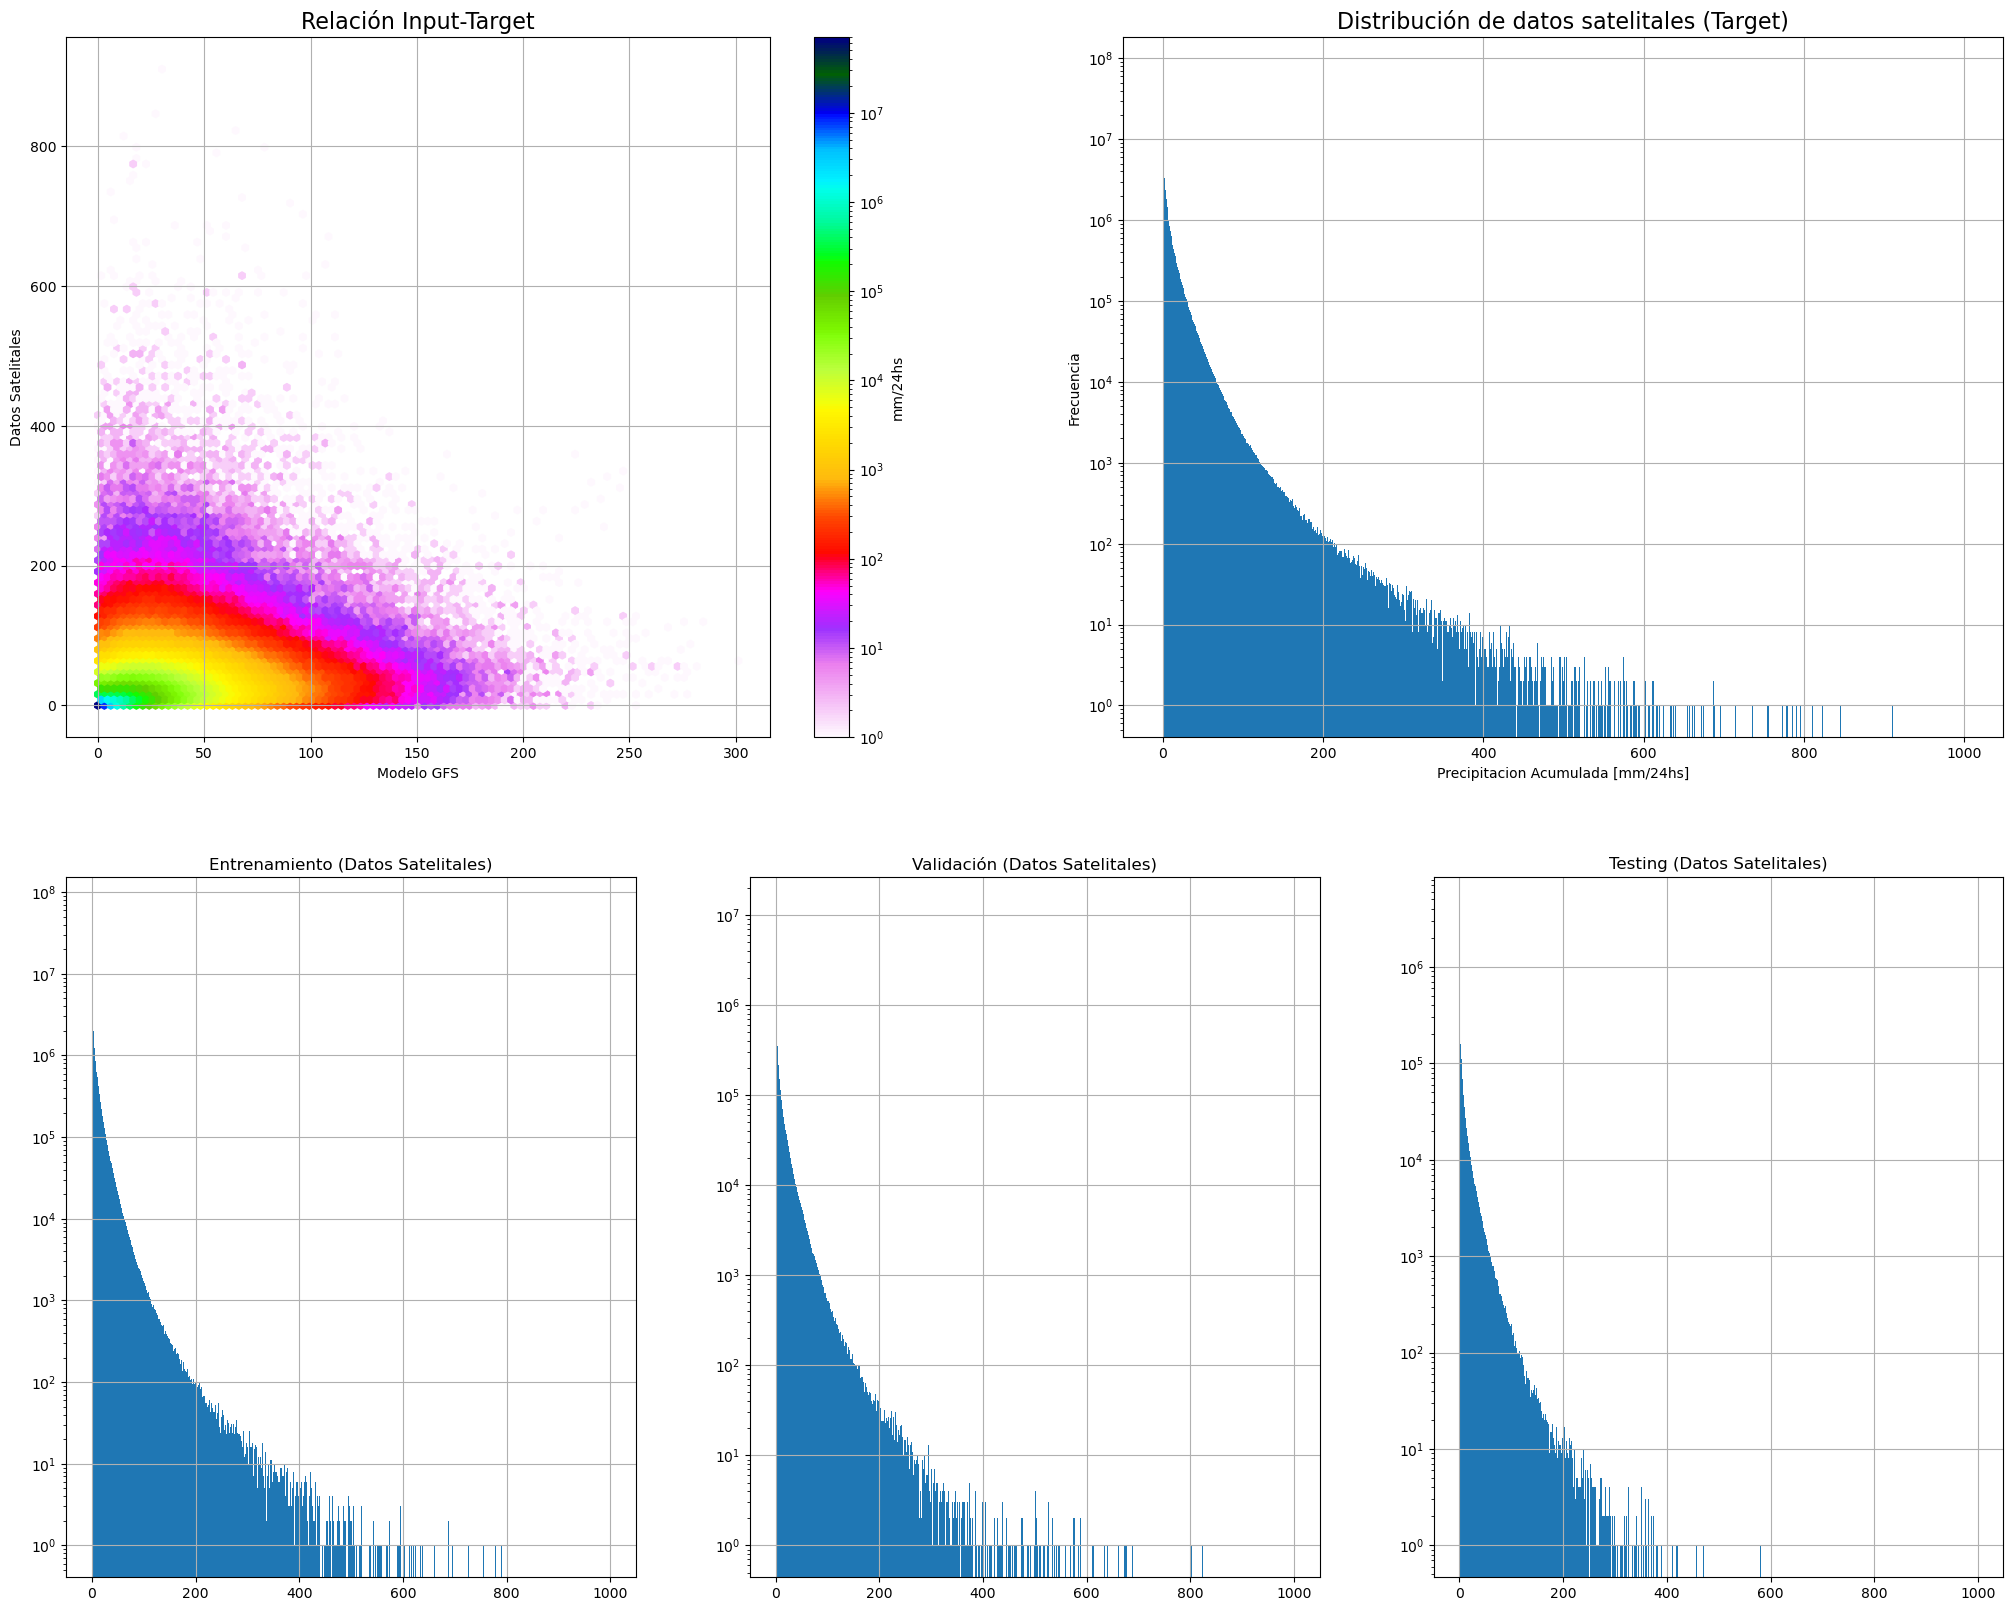

In [55]:
fig1 = plt.figure(figsize=(25,20))

plt.subplot(2,2,1)
plt.title("Relación Input-Target",fontsize=16)

#Estas agregando el conjunto de datos de entrenamiento y validacion en el mismo grafco para plotearlo
plt.hexbin(np.append(x_train,x_val,axis=0),np.append(y_train,y_val,axis=0),cmap = 'gist_ncar_r',bins='log',gridsize=100)

#Los ejes
plt.xlabel("Modelo GFS") ; plt.ylabel("Datos Satelitales")
#print(np.append(y_train,y_val,axis=0).std())
#print(np.append(y_train,y_val,axis=0).mean())

#La leyenda del primer grafico
cbar = plt.colorbar(orientation="vertical")
cbar.set_label("mm/24hs")
#cbar.set_ticks([0.1,5,10,25,50,75,100,125,150,175,200,300,400,500,600,700,800,1000])
#cbar.set_ticklabels([0.1,5,10,25,50,75,100,125,150,175,200,300,400,500,600,700,800,1000])


plt.grid()


#-----Distribucion del target---
plt.subplot(2,2,2)
plt.title("Distribución de datos satelitales (Target)",fontsize=16)

#Simplemente estoy uniendo los datos de entrenamiento y validacion del target
plt.hist(np.append(y_train,y_val,axis=0).flatten(),bins=range(1000))
plt.yscale("log")
plt.xlabel("Precipitacion Acumulada [mm/24hs]") ; plt.ylabel("Frecuencia")
plt.grid()
#--------------------------------
plt.subplot(2,3,4)
plt.title("Entrenamiento (Datos Satelitales)")
plt.hist(y_train.flatten(), bins=range(1000))
plt.yscale("log")
plt.grid()

plt.subplot(2,3,5)
plt.title("Validación (Datos Satelitales)")
plt.hist(y_val.flatten(), bins=range(1000))
plt.yscale("log")
plt.grid()

plt.subplot(2,3,6)
plt.title("Testing (Datos Satelitales)")
plt.hist(y_test.flatten(), bins=range(1000))
plt.yscale("log")
plt.grid()
#plt.savefig('/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/3-Prototipo_Red_Neuronal/grafiquito.png',dpi=500)


## Hiperparametros

Los hiperparametros son definidos, generalmente de forma manual, y determinan el entrenamiento de los modelos. En cambio un parametro, es estimado en el entrenamiento, por ejemplos pesos y bias.

Los hiperparametros con que más nos toparemos son los siguentes:

- **_Batch size_**: Es el tamaño de las muestras en las que se divide el dataset (no confundir con los datasets de entrenamiento/validación y testing), que se empaquetan en un tensor durante las iteraciones de entrenamiento. EL BATCH SIZE SIEMPRE ES MENOR O IGUAL AL TAMAÑO DE LOS DATOS DEL CONJUNTO DE ENTRENAMIENTO

- **_Épocas_**: Controla el número de pasadas completas por el conjunto de datos de entrenamiento. LA CANTIDAD DE EPOCAS ES MANUAL TEORICAMENTE ES INFINITO

- **_Tasa de aprendizaje / Learning Rate_**: Es el factor de escala (también llamado paso de movimiento) que proporciona la cantidad de ajuste que optimiza los parámetros (pesos y bias) a partir de considerar el gradiente de la función de costo.

- **_Función de costo_**: En cada paso de entrenamiento (es decir, para cada batch en cada eṕoca) se comparan la salida del modelo contra la verdad (Target), y esa comparación se cuantifica en una métrica que propongamos.


In [56]:
#Una forma de identificar la configuración que utilizamos
Modelo = "Convolucion"
Numero_exp = 7

#Hiperparametros
batch_size= 100
max_epochs = 3
learning_rate = 1e-4

#El learning rate decay seria algo que ayuda a converger. A partir de una cierta epoca el learning rate
#decay va decayendo a un ritmo de 0.1 
lr_decay = False
if lr_decay:
    milestones = [45] ; gamma=0.1

#Definimos la función de costo que queremos minimizar, y también el método de calculo sobre el batch.
MSE_Loss = torch.nn.MSELoss(reduction='mean')

tiene sentido que el learning rate tenga un orden de 10**-3 debido a tambien como es la funcion de costo. Generlamente esta estaandrizada, y tambien pensa en como seran los pesos 

In [57]:
Directorio_out = "./salidas/"+Modelo+"_"+Experimento+"_"+str(Numero_exp)+"/"

if not os.path.exists(Directorio_out):
    # Creo un nuevo directorio si no existe (para guardar las imagenes y datos)
    os.makedirs(Directorio_out)
    print("El nuevo directorio asociado a "+ Experimento +" "+str(Numero_exp)+" ha sido creado!")

### Definimos el modelo a utilizar

Utilizaremos el **_método forward_** para la construcción de nuestra arquitectura de red neuronal. El método forward (hacia adelante) como indica su nombre se basa en pasar nuestro input por los atributos que definimos en el **_class_**, en particular en el **_método init_** que para esto sirve. Es decir, vamos a hacer pasar el input por las sucesivas capas que componen la red neuronal hasta que llegar el output, la capa final.

Existe otra forma de construir la red neuronal, y es bajo la función **nn.Sequential**, que funciona igual que el método forward pero en este caso solo definimos las capas de la red neuronal, en el orden que queremos. Un ejemplo:

model = nn.Sequential(
  \
          nn.Linear(in_features = 16, out_features = 8),
  \
          nn.ReLU(),
  \
          nn.Linear(in_features = 8, out_features = 16),
  \
          nn.SiLU()
  \
        )

Usar el nn.Sequential es más sencillo e implica menos código, pero el beneficio del método forward es que permite construir de una forma más manipulable arquitecturas más complejas. Por ejemplo, si se requiere trabajar con varios inputs "independientes" entre si, y se quiere que la red neuronal en las primeras capas procese esos inputs de forma separada. Más especificamente con Redes Neuronales Convolucionales, si se requiere trabajar con **bloques** (que son un combinación de capas convolucionales para extraer ciertas características o generar procesamientos especificos), usar este método es más amigable.

Tips para optimizar lineas de código (válida para nn.Sequential también), se pueden componer las con capas de las red neuronal entre sí:

def forward(self, x):
\
&emsp; &emsp; self.activation_2(self.Linear_2(x))

Lo recomendable para que sea entendible es una capa de activación compuesta con la correspondiente capa neuronal.

In [58]:
class Convolucional(nn.Module):

    def __init__(self, nx, ny,filters): #Definimos los atributos de la clase
        super().__init__()

        #Nx serian tus entradas latitud (en nuestro ejemplo)
        #Ny tambien tu otra entrada lo que seria longitud
        self.nx, self.ny = nx, ny #Si se usan linears, es bueno guardalo...

        #in_chanels: seria tu matriz de entrada que es 1
        #out chanel: tu matriz de salida que es 16 salidas, una por cada kernel
        #kernel_size: que tamaño tiene el kernel 5x5
        #stride: pasos de iteracion en este caso se mueve un punto de reticula
        #padding: agrega 2 columna y dos filas
        #paddin_mode : reflect es que el borde se pone, en este caso uno similar al punto de reticula, podria ser 0
        #bias : True es buena idea activarlo
        self.conv_1 = nn.Conv2d(in_channels = filters[0],out_channels = filters[1], kernel_size=5 ,stride = 1, padding= 2, bias=True, padding_mode='reflect')
        self.conv_2 = nn.Conv2d(in_channels = filters[1], out_channels = filters[2], kernel_size=5 ,stride = 1, padding= 2, bias=True, padding_mode='reflect')
        
        self.activation_1 = nn.ReLU()
        self.activation_2 = nn.SiLU()
        
        #self.dropout_2d = nn.Dropout2d(p=0.2, inplace=False)
        
        #self.maxpool = nn.MaxPool2d(2)
        
        #self.transpconv_1 = nn.ConvTranspose2d(in_channels = filters[1],out_channels = filters[2], kernel_size=5 ,stride = 2, padding= 2, output_padding=1, bias=True)
        
        #self.Conv_BN_1 = torch.nn.BatchNorm2d(filters[1],affine=True) #Igual cantidad que la cantidad de filtros de salida
        

    def forward(self, x): #Ejecutamos con este método los atributos que definimos

        #de vector a matrices
        x = torch.unsqueeze(x,1) # x - Shape 4D: (batch size, filtros, nx, ny)
        
        x = self.conv_1(x)
        x = self.activation_1(x)

        x = self.conv_2(x)
        x = self.activation_2(x)
        #de matrices a vector
        return torch.squeeze(x)
    
#una imagen de entrada en el primer filtro

filters = [1,16,1]

#Aca instancia la clase como modelo
model = Convolucional(nx,ny,filters)
model.to(device) #Cargamos en memoria, de haber disponible GPU se computa por ahí
print("nx = {nx}","ny = {ny}")

nx = {nx} ny = {ny}



**<font color='green'>Preguntas</font>**

- **<font color='green'>En función de la arquitectura de red neuronal a utilizar. Cuente y discuta cuentos parámetros entrenables posee la red neuronal en cuestión y compare con la cantidad de datos que se poseen.</font>**

# Configuración de la Red Neuronal

## Descenso del gradiente y actualización de los parametros

El gradiente de una función apunta en la dirección de máximo crecimiento de esta, y bajo esta premisa se utiliza el método de optimización conocido como **descenso del gradiente**, que como insinua su nombre está asociado a la dirección contraria al gradiente de una función objetivo, que este caso es la función de costo que queremos minimizar. La longitud del paso de actualización de los parametros de la red neuronal estaran determinados entonces por los puntos donde la función de costo pasa de decrecer a crecer (es decir mínimos), siguiendo el siguiente proceso iterativo:
$$
  w_n^{t+1} = w_n^{t} - \lambda * \frac{\partial{Loss}}{\partial{w_n^{t}}} \qquad w_n^{t}: Peso \; n-ésimo \; en \; paso \; de \; actualización \; t, \; \lambda: Learning \: Rate
$$ (my_other_label)
Cuando la función de costo satisface ciertas condiciones de regularidad (son del tipo C) el algoritmo converge a un mínimo local, que termina siendo un mínimo global en el caso de funciones estrictamente convexas. Por este motivo, es que es deseable que las funciones de costo que utilicemos sea convexas (-> U ), como por ejemplo el MSE.

## Otras configuraciones: Optimizador e Inicialización de pesos.

Estrictamente lo siguiente que definiremos son hiperparametros también. Ya que son configuraciones que definimos en la etapa de pre-entrenamiento, y son sumamente importantes porque configuran el objetivo y forma de entrenamiento. 

Los pesos se actualizaran siguiendo la idea del algoritmo de descenso del gradiente, donde la función a minimizar es la **_Función de costo (Loss Function)_** que definimos.

A partir del algoritmo de **_Backprogation_** se propagara el costo y se imputará sobre los parámetros (pesos y bias) de la red neuronal.

El **_Optimizador_** es el método de actualización de los pesos en cada época. En particular en este caso, utilizaremos ADAM (ADAptative Moment estimation). Brevemente lo que hace es computar un learning rate para cada paramametro (la parte adaptativa del optimizador) y también guarda el decaimiento promedio de los gradientes anteriores. Esto último en las primeras épocas es donde más se hace notar este efecto, porque los gradientes suelen ser mayores/bruscos adaptandose a los datos.

El "punto de partida" de los parametros a optimizar para la minimización de la Función de costo, está dada por la **_distribución inicial de los pesos_**. La cual es importante considerar debido a que puede colaborar a lograr una rápida convergencia de la red neuronal hacia el mínimo global de la función de costo (de encontrarse) o por el contrario atentar contra esto y requerir un mayor número de eṕocas para lograr la convergencia.

Notas sobre inicialización de pesos: https://eva.fing.edu.uy/pluginfile.php/317369/mod_resource/content/3/c9.pdf

Es una funcion para iniciar los pesos de manera random, la magnitud de los pesos va decayendo al pasar de las capas 

In [59]:
#Inicializas tu kernel de manera aleatoria
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_normal_(m.weight) #ayuda a que el primer peso sea efectivo
            torch.nn.init.constant_(m.bias, 0)

#Mi modelo ya tiene un valor para los pesos 
initialize_weights(model) #Definimos los pesos iniciales con los cuales inicia el modelo antes de entrenarlo

#Definimos el optimizador (descenso de gradiente)
#Params conjunto de parametros que definen mi kernel
#Para cada celdita del kernel tenes un 1 parametro X la cantidad de parametros 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

#Definimos el Scheduler para el Learning Rate
if lr_decay:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma = gamma, verbose = True)

Solamente el modelo tiene definido los pesos iniciales hasta aca

# Entrenamiento de la Red Neuronal

## DataLoader

Este objeto no sabe del modelo, solo tiene informacion de los datos

In [60]:
#Preparamos los 3 conjuntos que definimos entrenamiento, validación y testing para que ingresen al dataloader

#Input matriz de 40x40x31
#Output matriz de 40x40x31
train_subset = ds.set_up_data(Data=Data, Input = x_train, Target = y_train)
val_subset = ds.set_up_data(Data=Data, Input = x_val,   Target = y_val)
test_subset = ds.set_up_data(Data=Data, Input = x_test,  Target = y_test)

#Definimos los dataloaders
#El dataloader de train tiene definido el batch_size, no asi los de validacion y test.
#Generalmente porque en comparación son mucho más chicos.
dataloader_train = DataLoader(train_subset, batch_size = batch_size, shuffle=True)   
dataloader_val   = DataLoader(val_subset , batch_size=len( val_subset) )
dataloader_test  = DataLoader(test_subset , batch_size=len( test_subset) )

## Entrenando la Red Neuronal


**<font color='red'>Teniendo en cuenta lo anterior y la función de costo definida. Observe como en cada época varia la loss para el conjunto de entrenamiento y el de validación.</font>**

In [61]:
#Listas donde guardamos loss de entrenamiento, y para el de validación la loss y las métricas de evaluación.
RMSE, BIAS, Corr_P, Corr_S = [], [], [], []
loss_train, loss_val = [], []

#Uno recorre varias veces los mismos datos para acercarse al minimo 
#recordemos que 
for epoch in range(max_epochs):
  print('Epoca: '+ str(epoch+1) + ' de ' + str(max_epochs) )

  #Entrenamiento del modelo        
  model.train()  #Esto le dice al modelo que se comporte en modo entrenamiento.

  sum_loss = 0.0
  batch_counter = 0

  # Iteramos sobre los minibatches. 
  for inputs, target in dataloader_train:

    #Enviamos los datos a la memoria.
    inputs, target = inputs.to(device), target.to(device)
    #-print( 'Batch ' + str(batch_counter) )

    optimizer.zero_grad()

    #Sobre los 100 inputs que salieron del dataloader despues de la relu silu y todo eso
    outputs = model(inputs) 
            
    loss = MSE_Loss(outputs.float(), target.float())
                    
    loss.backward() #la derivada
    optimizer.step() #calcula el learning rate y todo eso
                    
    batch_counter += 1
    sum_loss = sum_loss + loss.item()

  if lr_decay:
    scheduler.step()

  #Calculamos la loss media sobre todos los minibatches 
  loss_train.append( sum_loss / batch_counter )

  #---------------------------------------------------------------------

  #ACA EVALUA COMO TE VA DANDO EN CADA EPOCA EL CONJUNTO DE VALIDACION Y TESTEO NO ENTRENA SOLO EVALUA
  #SI LO HARIAS EN OTRO BLOQUE LO QUE PASARIA ES Q LO EVALUARIAS EN TODOO EL CON JUNTO
  #Calculamos la funcion de costo para la muestra de validacion.
  input_val , target_val = next( iter( dataloader_val ) )
  input_val , target_val = input_val.detach().to(device) , target_val.detach().to(device) 
  with torch.no_grad():
    output_val = model( input_val )

  loss_val.append( MSE_Loss( output_val , target_val ).item() )

  #Calculamos la funcion de costo para la muestra de testing.
  model.eval()   #Esto le dice al modelo que lo usaremos para evaluarlo (no para entrenamiento)
  input_test , target_test = next( iter( dataloader_test ) )
  input_test , target_test = input_test.detach().to(device) , target_test.detach().to(device) 
  #zzprint( input_test.shape )
  with torch.no_grad():
    output_test = model( input_test )

  #Calculo de la loss de la epoca
  print('Loss Train: ', str(loss_train[epoch]))
  print('Loss Val:   ', str(loss_val[epoch]))

  ###################################
  np_input_test  = ds.denorm( input_test.numpy()  , dataloader_test.dataset.xmin, dataloader_test.dataset.xmax )
  np_target_test = ds.denorm( target_test.numpy() , dataloader_test.dataset.ymin, dataloader_test.dataset.ymax )
    
  #Mis matrices desnormalizadas
  np_output_test = ds.denorm( output_test.detach().numpy() , dataloader_test.dataset.ymin, dataloader_test.dataset.ymax )
    
  np_input_val  = ds.denorm( input_val.numpy()  , dataloader_val.dataset.xmin, dataloader_val.dataset.xmax )
  np_target_val = ds.denorm( target_val.numpy() , dataloader_val.dataset.ymin, dataloader_val.dataset.ymax )
  np_output_val = ds.denorm( output_val.detach().numpy() , dataloader_val.dataset.ymin, dataloader_val.dataset.ymax )
  

  ##Calculo de metricas RMSE, BIAS, Correlacion de Pearson y Spearman
  RMSE.append( ver.rmse( np_output_val , np_target_val ) )
  BIAS.append( ver.bias( np_output_val , np_target_val ) )
  Corr_P.append( ver.corr_P( np_output_val , np_target_val ) )
  Corr_S.append( ver.corr_S( np_output_val , np_target_val ) ) 
  

Epoca: 1 de 3


Loss Train:  0.0002912601802085716
Loss Val:    0.0001258903939742595
Epoca: 2 de 3
Loss Train:  8.788446692791293e-05
Loss Val:    8.880907262209803e-05
Epoca: 3 de 3
Loss Train:  6.470885452117881e-05
Loss Val:    7.637813541805372e-05


Anteriormente creo que con lo predeterminado llegaba a 38 o algo asi y oscilaba aunque es verdad que tambien estaba mal noramlizado

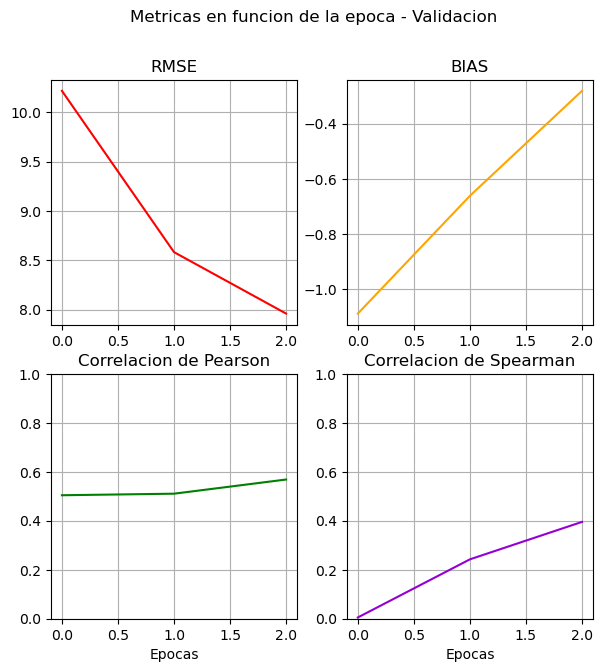

In [68]:
fig = plt.figure(figsize=(7,7))
plt.suptitle("Metricas en funcion de la epoca - Validacion")
        
plt.subplot(2,2,1)
plt.title("RMSE")
plt.plot(range(max_epochs), RMSE,color="red")
plt.grid()

plt.subplot(2,2,2)
plt.title("BIAS")
plt.plot(range(max_epochs), BIAS, color="orange")
plt.grid()

plt.subplot(2,2,3)
plt.title("Correlacion de Pearson")
plt.plot(range(max_epochs), Corr_P, color="green")
plt.ylim(0,1)
plt.xlabel("Epocas")
plt.grid()

plt.subplot(2,2,4)
plt.title("Correlacion de Spearman")
plt.plot(range(max_epochs), Corr_S, color="darkviolet")
plt.xlabel("Epocas")
plt.ylim(0,1)
plt.grid()
        
    #plt.savefig(Dir_plot+"Scores_series.png",dpi=100,bbox_inches="tight")
   # plt.close()



Me gustaria tener un codigo que plotee para ver que tan distintos son la entrada y salida.
Mas que nada los datos de output con los q evaluo no los de entrenamiento 

jUAN DIce que la loss es baja por el orden de magnitud y no tanto porq el modelo sea perfecto.

In [63]:
variable = True

if variable:
    torch.save(model.state_dict(), Directorio_out+"Modelo_exp_"+str(Numero_exp)+".pth")
    
if variable: #Guardar los datos de test
    np.savez(Directorio_out+"Datos_test_"+Input_name+"_vs_"+Target_name+"_"+str(Numero_exp)+".npz",
         Input= np_input_test,
         Target= np_target_test,
         Modelo= np_output_test,
         Dates = fechas_testeo,
         loss_train = loss_train, loss_val = loss_val,
         RMSE = RMSE, BIAS = BIAS, Corr_P = Corr_P, Corr_S = Corr_S,
         Experimento = Experimento, Input_name = Input_name, Target_name = Target_name,
         max_epochs = max_epochs, nx = nx, ny = ny,
         fechas_test = fechas_testeo,latitudes=latitudes,longitudes=longitudes )

# abrimos los datos de salida

In [64]:
path_salida = '/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/3-Prototipo_Red_Neuronal/salidas/Convolucion_pp_medios_gfsvspp_medios_gsmap_7/Datos_test_pp_medios_gfs_vs_pp_medios_gsmap_7.npz'
archivo = np.load(path_salida)

In [65]:
archivo.files

['Input',
 'Target',
 'Modelo',
 'Dates',
 'loss_train',
 'loss_val',
 'RMSE',
 'BIAS',
 'Corr_P',
 'Corr_S',
 'Experimento',
 'Input_name',
 'Target_name',
 'max_epochs',
 'nx',
 'ny',
 'fechas_test',
 'latitudes',
 'longitudes']

In [66]:
RMSE = archivo['RMSE']
BIAS = archivo['BIAS']
max_epochs = archivo['max_epochs']
Corr_P = archivo['Corr_P']
Corr_S = archivo['Corr_S']

In [71]:
latitudes_out = archivo['latitudes']
longitudes_out = archivo['longitudes']

In [60]:
archivo.files

['Input',
 'Target',
 'Modelo',
 'loss_train',
 'loss_val',
 'RMSE',
 'BIAS',
 'Corr_P',
 'Corr_S',
 'Experimento',
 'Input_name',
 'Target_name',
 'max_epochs',
 'nx',
 'ny']

In [ ]:
archivo

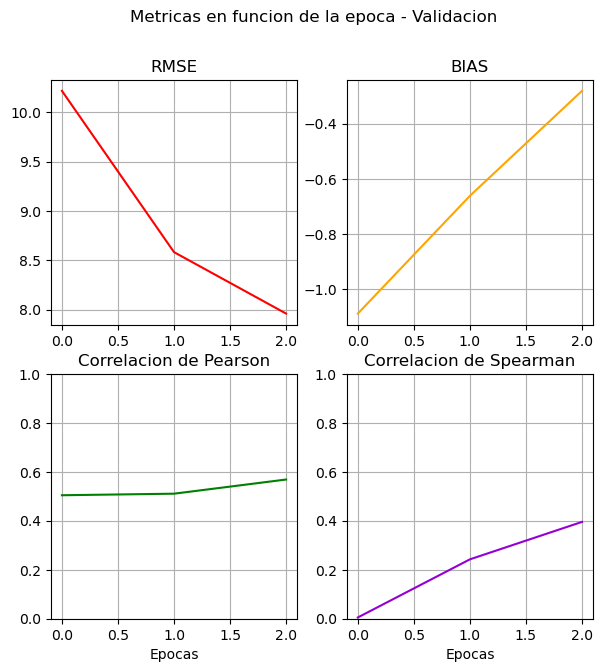

In [67]:
fig = plt.figure(figsize=(7,7))
plt.suptitle("Metricas en funcion de la epoca - Validacion")
        
plt.subplot(2,2,1)
plt.title("RMSE")
plt.plot(range(max_epochs), RMSE,color="red")
plt.grid()

plt.subplot(2,2,2)
plt.title("BIAS")
plt.plot(range(max_epochs), BIAS, color="orange")
plt.grid()

plt.subplot(2,2,3)
plt.title("Correlacion de Pearson")
plt.plot(range(max_epochs), Corr_P, color="green")
plt.ylim(0,1)
plt.xlabel("Epocas")
plt.grid()

plt.subplot(2,2,4)
plt.title("Correlacion de Spearman")
plt.plot(range(max_epochs), Corr_S, color="darkviolet")
plt.xlabel("Epocas")
plt.ylim(0,1)
plt.grid()


In [67]:
loss_train = archivo['loss_train']
loss_val = archivo['loss_val']

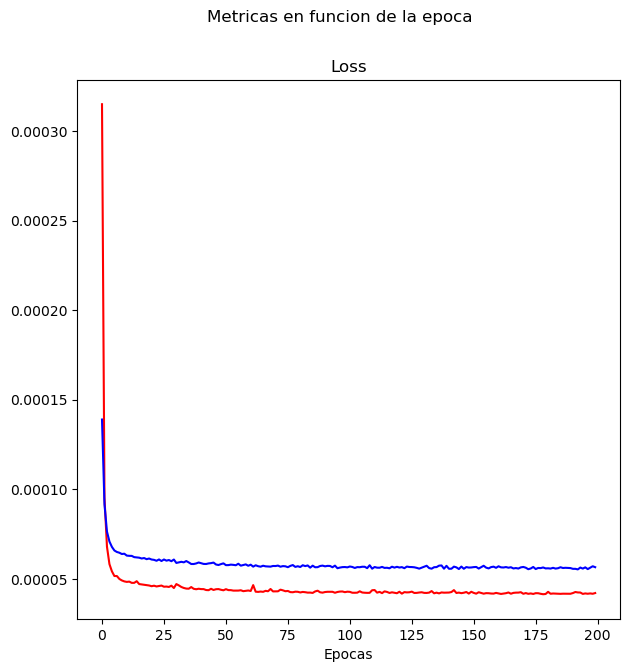

In [69]:
fig = plt.figure(figsize=(7,7))
plt.suptitle("Metricas en funcion de la epoca")
        
plt.title("Loss")
plt.plot(range(max_epochs), loss_train, color="red")
plt.plot(range(max_epochs), loss_val, color="blue")

#plt.ylim(0,1)
plt.xlabel("Epocas")
plt.grid()
#plt.plot(range(max_epochs), RMSE,color="red")
plt.grid()

Quiza estaria bueno que te traigas tambien las latitudes y longitudes

In [26]:
#archivo['nx']

array(101)

In [69]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:

#Area no tropical o de Clima de latitudes medias
lat_north_med = -20
lat_south_med =  -45
long_west_med = 285
long_east_med = 320

#Archivo unico
my_path_unico = '/home/fernando.huaranca/datosmunin/Gsmap_24hs/Gsmap_R0.25_24hs_2000-01-01.npz'
my_file_unico = np.load(my_path_unico)

#Extraemos las latitudes y longitudes de 1 archivo solo
latitudes = my_file_unico['latitudes']
longitudes = my_file_unico['longitudes']

#Definimos los indices y regiones 

#AREA DE CLIMA DE LATITUDES MEDIAS---------------
lat_index_med = np.where((latitudes >= lat_south_med) & (latitudes<=lat_north_med))[0]
LAT_med = latitudes[lat_index_med] 

long_index_med = np.where((longitudes >= long_west_med) & (longitudes<=long_east_med))[0]
LONG_med = longitudes[long_index_med]


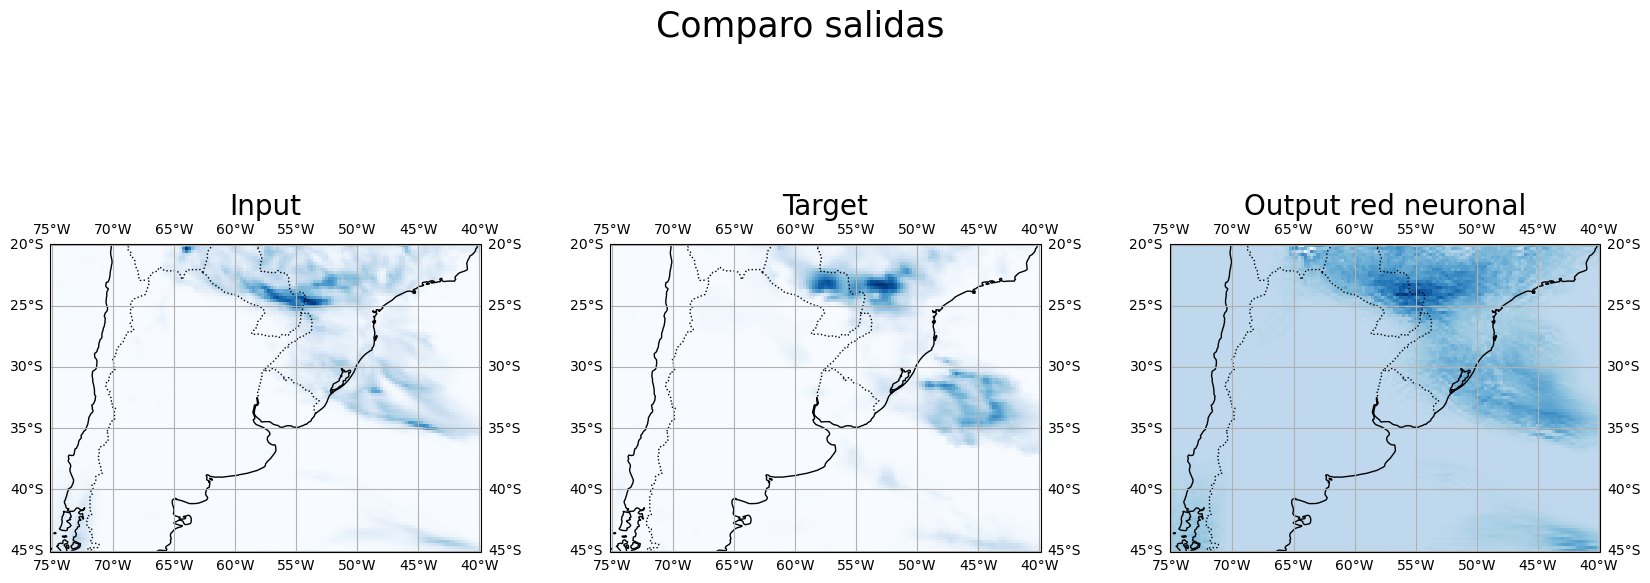

In [ ]:
# Se crea una figura y un arreglo de ejes

fig, axs = plt.subplots(1,3, figsize=(20, 8),subplot_kw={'projection': ccrs.PlateCarree()})

plt.suptitle('Comparo salidas',fontsize=25)

#-------------Input-----

#Utilizando el metodo pcolormersh se crea un mapa de colores.
#Transform especifica la proyeccion utilizada
ax1 = axs[0].pcolormesh(LONG_med, LAT_med, np_input_test[1,:,:], transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')


#Se agregan caracteristicas geograficas a la trama
axs[0].add_feature(cfeature.COASTLINE)
axs[0].add_feature(cfeature.BORDERS, linestyle=':') #estilo de linea punteada

#Agrega lineas de cuadricula al mapa. Indica que se dibujen lineas de latitud y longitud
#dms = True muestra las etiquetas en grados minutos y segundos
axs[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axs[0].set_title('Input',fontsize=20)
#-------------------------Target-----------------

ax2 = axs[1].pcolormesh(LONG_med, LAT_med, np_target_test[1,:,:], transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')
#print(axs)
#Se agregan caracteristicas geograficas a la trama
axs[1].add_feature(cfeature.COASTLINE)
axs[1].add_feature(cfeature.BORDERS, linestyle=':') #estilo de linea punteada
#Agrega lineas de cuadricula al mapa. Indica que se dibujen lineas de latitud y longitud
#dms = True muestra las etiquetas en grados minutos y segundos
axs[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axs[1].set_title('Target',fontsize=20)

#-----------Output-------------

ax3 = axs[2].pcolormesh(LONG_med, LAT_med, np_output_test[1,:,:], transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')
#print(axs)
#Se agregan caracteristicas geograficas a la trama
axs[2].add_feature(cfeature.COASTLINE)
axs[2].add_feature(cfeature.BORDERS, linestyle=':') #estilo de linea punteada
#Agrega lineas de cuadricula al mapa. Indica que se dibujen lineas de latitud y longitud
#dms = True muestra las etiquetas en grados minutos y segundos
axs[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axs[2].set_title('Output red neuronal',fontsize=20)
# Añadir una barra de colores

# Ajustar los márgenes entre los subgráficos horizontalmente
plt.subplots_adjust(wspace=0.3)  # Cambia el valor según sea necesario


Armar un conjunto de casos

Tener en cuenta la fecha , o cuanto llovio los casos extremos del testing 

Del conjunto del testing, chequear en el target los extremos, para ver si capturamos la magnitud de los eventos

Histogramas, scores de las tablas de contigencia . Metricas para ver el periodo de testing el gfs contra el satelite, la red contra las observaciones

In [76]:
#Testeo un dia

dia = 3


Input = archivo['Input']
Target = archivo['Target']
Red = archivo['Modelo']
Dates = archivo['Dates']

Input = Input[dia,:,:]
Target = Target[dia,:,:]
Red = Red[dia,:,:]
Dates = Dates[dia]

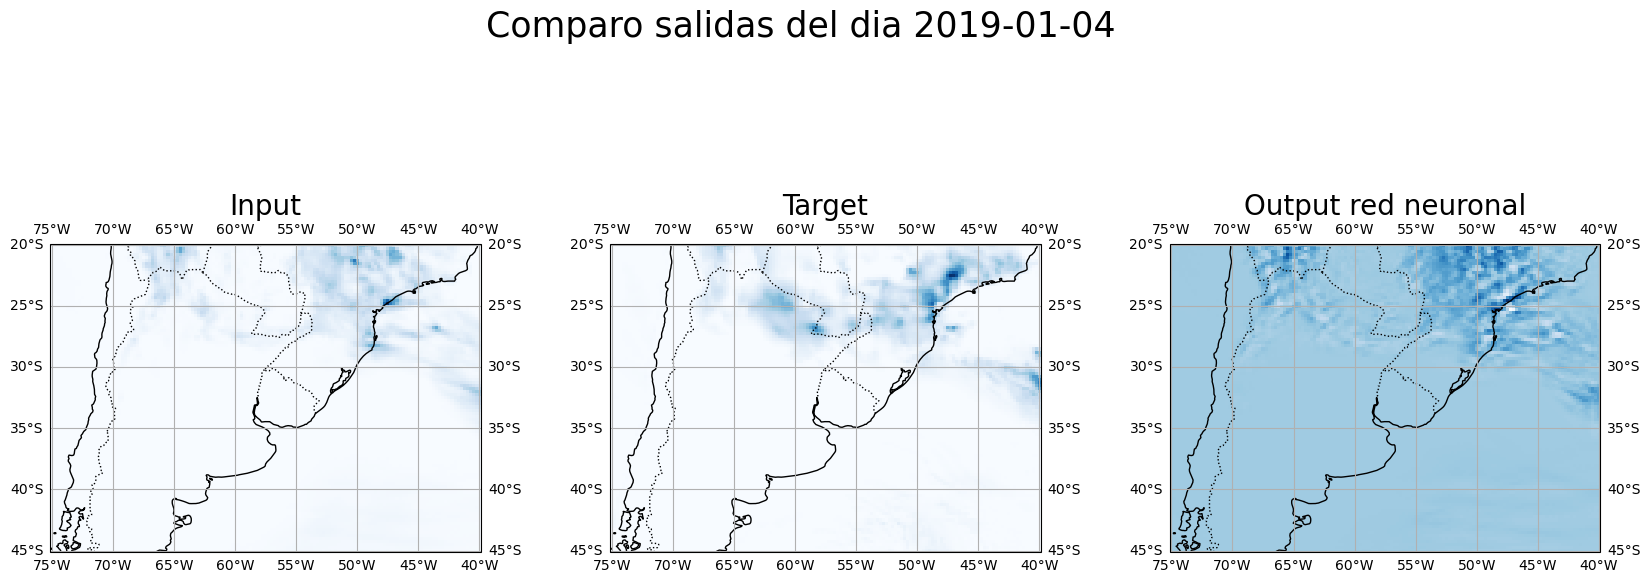

In [78]:
# Se crea una figura y un arreglo de ejes

fig, axs = plt.subplots(1,3, figsize=(20, 8),subplot_kw={'projection': ccrs.PlateCarree()})

plt.suptitle(f'Comparo salidas del dia {Dates}',fontsize=25)

#-------------Input-----

#Utilizando el metodo pcolormersh se crea un mapa de colores.
#Transform especifica la proyeccion utilizada
ax1 = axs[0].pcolormesh(longitudes_out, latitudes_out, Input, transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')


#Se agregan caracteristicas geograficas a la trama
axs[0].add_feature(cfeature.COASTLINE)
axs[0].add_feature(cfeature.BORDERS, linestyle=':') #estilo de linea punteada

#Agrega lineas de cuadricula al mapa. Indica que se dibujen lineas de latitud y longitud
#dms = True muestra las etiquetas en grados minutos y segundos
axs[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axs[0].set_title('Input',fontsize=20)
#-------------------------Target-----------------

ax2 = axs[1].pcolormesh(longitudes_out, latitudes_out, Target, transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')
#print(axs)
#Se agregan caracteristicas geograficas a la trama
axs[1].add_feature(cfeature.COASTLINE)
axs[1].add_feature(cfeature.BORDERS, linestyle=':') #estilo de linea punteada
#Agrega lineas de cuadricula al mapa. Indica que se dibujen lineas de latitud y longitud
#dms = True muestra las etiquetas en grados minutos y segundos
axs[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axs[1].set_title('Target',fontsize=20)

#-----------Output-------------

ax3 = axs[2].pcolormesh(longitudes_out, latitudes_out, Red, transform=ccrs.PlateCarree(), cmap='Blues', shading='auto')
#print(axs)
#Se agregan caracteristicas geograficas a la trama
axs[2].add_feature(cfeature.COASTLINE)
axs[2].add_feature(cfeature.BORDERS, linestyle=':') #estilo de linea punteada
#Agrega lineas de cuadricula al mapa. Indica que se dibujen lineas de latitud y longitud
#dms = True muestra las etiquetas en grados minutos y segundos
axs[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
axs[2].set_title('Output red neuronal',fontsize=20)
# Añadir una barra de colores

# Ajustar los márgenes entre los subgráficos horizontalmente
plt.subplots_adjust(wspace=0.3)  # Cambia el valor según sea necesario


# Hasta aca llega juan lo demas son testeos random

### Ploteamos y evaluamos el conjunto de Testing

In [27]:
np_output_test.shape

(730, 101, 141)

In [25]:
Muestras = random.sample(range(Data["len_test"]),10)

plots.plotting(Directorio_out, np_input_test , np_target_test , np_output_test ,
                loss_train, loss_val, 
                RMSE, BIAS, Corr_P, Corr_S,
                Experimento, Input_name, Target_name,
                max_epochs, Muestras, nx ,ny)

TypeError: cannot unpack non-iterable NoneType object

**<font color='green'>Preguntas</font>**

**<font color='green'>Observando la figura de la evolución en función de la época. ¿Cómo fué su evolución? ¿Incurrimos en Underfitting u Overfitting?</font>**

**<font color='green'>Discuta la evolución de los scores en función de la época. ¿Sobre cual conjunto se están calculando?</font>**

**<font color='green'>Observe similitudes y diferencias entre el target y el output de algunos de los ejemplos de salida graficados. ¿A que se los puede atribuir?</font>**

**<font color='green'> </font>**

**<font color='green'>Preguntas</font>**


## Guardando el modelo entrenado, y los datos de Testing 

In [37]:
Directorio_out

'./salidas/Convolucion_pp_medios_gfsvspp_medios_gsmap_0/'

In [38]:
Directorio_out = '/home/fernando.huaranca/datosmunin2/Thesis_Neuronal_Network/work/3-Prototipo_Red_Neuronal/salidas/Convolucion_pp_medios_gfsvspp_medios_gsmap_0'

In [41]:
torch.save(model.state_dict(), Directorio_out+"Modelo_exp_"+str(Numero_exp)+".pth")
    
#Guardar los datos de test
np.savez(Directorio_out+"Datos_test_"+Input_name+"_vs_"+Target_name+"_"+str(Numero_exp)+".npz",
         Input=input_test.reshape(input_test.shape[0],nx,ny),
         Target=target_test.reshape(target_test.shape[0],nx,ny),
         Modelo=output_test.reshape(output_test.shape[0],nx,ny),
         loss_train = loss_train, loss_val = loss_val,
         RMSE = RMSE, BIAS = BIAS, Corr_P = Corr_P, Corr_S = Corr_S,
         Experimento = Experimento, Input_name = Input_name, Target_name = Target_name,
         max_epochs = max_epochs, nx = nx, ny = ny)

RuntimeError: shape '[141, 101, 141]' is invalid for input of size 10395930

### Para levantar los parametros del modelo que ya entrenamos

In [ ]:
if False:
    model.load_state_dict(torch.load(Directorio_out+"Modelo_exp_"+str(Numero_exp)+".pth"))

# Consignas

**<font color='red'>Realicemos otras pruebas... Indique números de experimento diferentes para luego comparar (está en la sección de hiperparámetros), anote la configuración utilizada, en particular la inicial para ser de referencia para analizar la sensibilidad.</font>**

## 1 - Normalización de los datos

**<font color='pink'>Inicialmente trabajamos con una normalización del tipo [0,1], ahora elimine la normalización y entrene y comparare el modelo.</font>**

## 2- Batch Normalization

**<font color='pink'>Aplique batch normalization. ¿Que modificó? ¿Cómo fué su desempeño respecto del anterior?</font>**

## 3 - Dropout

**<font color='pink'>Ahora activemos el dropout (descomentelo en la sección que construimos el modelo) y setee la configuración de referencia.</font>**

- **<font color='green'>Cuando aplique Dropout. ¿Que pasaría si CADA VEZ que ingresa un input, en las capas que se aplique el dropout, cierto porcentaje de neuronas se apagan? Realice la prueba y compare con el experimento de referencia.</font>**

Ilustrando:

![alternative text](./images_CONV/dropout.webp)

Nota: El efecto de dropout solo ocurre durante el entrenamiento de la red, no sobre el testing.

![alternative text](./images_CONV/dropout_train_test.webp)

- **<font color='green'>Modifique la probabilidad del dropout. ¿Que ocurre si tomamos los casos extremos? Realice la prueba.</font>**

## 4 - Data Augmentation

Es un recurso para aumentar de manera artificial los datos con los cuales entrenamos la red neuronal. Existen diferentes metodologías para llevarlo a cabo, por ejemplo a la imagen original rotarla o añadirle un ruido, que altera suavemente a la imagen, generando una imagen nueva, pero que conserve sus características. En este caso, se deja la opción realizar un data augmentation con rotación alrededor del eje horizontal, vertical y de ambos, de esta forma por cada imagen perteneciente al entrenamiento, se generaran 3 imagenes adicionales, lo cual cuadriplica el tamaño del dataset de entrenamiento.

**<font color='green'> ¿Cúal imagen es la real?<font>**

![alternative text](./images_CONV/ciclogenesis_flipH_rotate2.png)![alternative text](./images_CONV/ciclogenesis_rotate2.png) ![alternative text](./images_CONV/ciclogenesis_flipHV.png) ![alternative text](./images_CONV/ciclogenesis_flipV.png)

![alternative text](./images_CONV/ciclogenesis_rotate1.png)![alternative text](./images_CONV/ciclogenesis_flipH_rotate1.png)![alternative text](./images_CONV/ciclogenesis_flipH.png) ![alternative text](./images_CONV/ciclogenesis.png)

**<font color='pink'>Ahora activemos el Data augmentation, setee la configuración de referencia.<font>**

## 5 - Más datos

**<font color='pink'>Remueva el dropout. Vaya al script de set_dataset, en particular a la función get_data y utilice todos los datos para el entrenamiento. LUEGO REINICIE EL KERNEL y ejecute la notebook. ¿Cómo fué el desempeño del modelo? </font>**

## 6 - Operadores dimensionales en Convolucionales: Maxpooling y Convolución Transpuesta

**<font color='pink'>Entre las capas convoluciones con las cuales venimos trabajando, incorpore una capa de Maxpooling y al final de la red una Convolución Transpuesta.</font>**

## 7 - Variando los filtros de la red

**<font color='pink'>Aumente o reduzca la cantidad de filtros de las capas convolucionales (no el in inicial y el out final) ¿Qué estamos haciendo? Observe el tiempo de entrenamiento y compare el resultado con la arquitectura inicial.</font>**

## 8 - Variando los argumentos de las convolucionales

**<font color='red'>CALCULE LAS DIMENSIONES, utilice la función de abajo que se le da los argumento y calcula la dimensión de salida.</font>**

**<font color='pink'>Aumente o reduzca el tamaño de los kernels, stride, padding y dilatation. Observe el tiempo de entrenamiento y compare el resultado con la arquitectura inicial.</font>**

**<font color='pink'>También considere variar el modo de padding, busque en la [página](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) los tipos de modos de padding que existen, ¿Qué hacen cada uno?.</font>**

**[Página](https://madebyollin.github.io/convnet-calculator/) para calcular dimensiones en convolucionales y maxpooling** 

In [ ]:
def conv(size,kernel,stride,padding,dilatation):
    
    return (size+2*padding-dilatation*(kernel-1)-1)/stride +1

def maxpooling(size,kernel,padding,dilatation): #idem convolución, pero para el stride por default es el tamaño del kernel
    stride = kernel
    return (size+2*padding-dilatation*(kernel-1)-1)/stride +1

def transposeConv(size,kernel,stride,padding,dilatation,output_padding):
    
    return (size-1)*stride-2*padding+dilatation*(kernel-1)+output_padding+1

In [ ]:
print(conv(size = 40, kernel = 11, stride = 1, padding = 5, dilatation = 1))
print(maxpooling(size = 40, kernel= 2, padding = 0,dilatation = 1))
print(transposeConv(size = 20, kernel = 4, stride = 2, padding = 1,  dilatation = 1, output_padding = 0))

## 9 - Libre

**<font color='pink'>Ahora juegue y utilice diferentes pruebas combinando todo lo visto. ¿Cual fué la mejor combinación obtenida?</font>**

# Bibliografía

- Deep Learning with Pytorch. Stevens E., Antiga L., & Viehmann T. Manning Publications, 2020.

- https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0

- https://medium.com/@monadsblog/dropout-tales-57cf0191f5af